In [5]:
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit import Chem
%matplotlib inline
from rdkit.Chem import Draw
from IPython.core.display import display, HTML
from rdkit.Chem import AllChem
import zlib, re
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os, sys
import pickle
import parmed as pm
import csv
import nglview
import psi4
import mdtraj as md

hartree_to_kJ_mol = 2625.499638

gaff_default = os.path.join("../data/gaff2.xml")


In [2]:
name = 'molDWRow_298'
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))
t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t1-smiles']


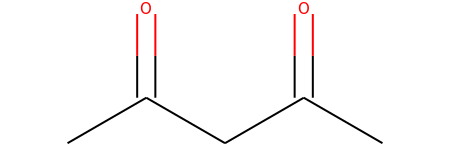

In [3]:
Chem.MolFromSmiles(t1_smiles)

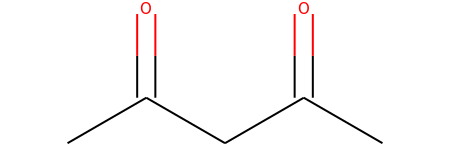

In [4]:
Chem.MolFromSmiles(t2_smiles)

In [ ]:
ith_snapshots = 10


psi4.set_memory('4000 MB')
for t_id in [1, 2]:
    m = Chem.MolFromPDBFile(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.pdb", removeHs=False)
    
    AllChem.Compute2DCoords(m)
    display(utils.mol_with_atom_index(m))
    e_list = []
    traj = md.load(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}_gaff.dcd", top=f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.pdb")
    trange = range(0,traj.n_frames, ith_snapshots)
    trange = tqdm(trange)


    for i in trange:
        traj[i].save_xyz(f"../data/comparision_gaff_qm/{name}/{name}_{t_id}_{i}.xyz")
        f = open(f"comparision_gaff_qm/{name}/{name}_{t_id}_{i}.xyz")
        s = ''
        for line in f:

            line = re.sub(r"C\d+", "C", line)
            line = re.sub(r"O\d+", "O", line)
            line = re.sub(r"H\d+", "H", line)
            line = re.sub(r"Cl\d+", "Cl", line)
            line = re.sub(r"F\d+", "F", line)
            line = re.sub(r"S\d+", "S", line)
            s += line        
        g = psi4.geometry(s)
        e = psi4.energy('wB97X/6-31g*')
        e_list.append(e)
        
    energy_file = open(f"../data/comparision_gaff_qm/{name}/psi4_energy_with_wB97X_631g_{name}_{t_id}_{i}.csv", 'w')
    for idx, e in zip(range(0,traj.n_frames, ith_snapshots), e_list):
        energy_file.write("{idx}, {e}\n")
    energy_file.close()
        
        

molDWRow_298


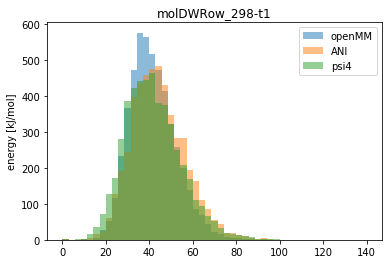

molDWRow_298


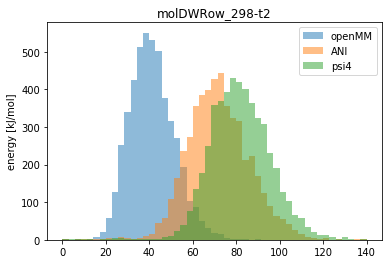

In [10]:
for t_id in [1, 2]:
    print(name)
    pot_energy_openMM = []
    pot_energy_ani = []
    pot_energy_psi4 = []

    with open(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}_gaff_energy.csv", newline='') as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_openMM.append(float(row[2]))

    with open(f"../data/comparision_gaff_qm/{name}/ani_{name}_{t_id}.csv") as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_ani.append(float(row[1]))

    with open(f"../data/comparision_gaff_qm/{name}/psi4_energy_with_wB97X_631g_{name}_{t_id}.csv") as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_psi4.append(float(row[1]) * hartree_to_kJ_mol)

    pot_energy_openMM = list(np.asarray(pot_energy_openMM[::10]) - min(pot_energy_openMM[::10]))
    pot_energy_ani = list(np.asarray(pot_energy_ani) - min(pot_energy_ani))
    pot_energy_psi4 = list(np.asarray(pot_energy_psi4) - min(pot_energy_psi4))

    plt.hist(pot_energy_openMM, np.linspace(0, 140), label='openMM', alpha=0.5 )
    plt.hist(pot_energy_ani, np.linspace(0, 140) , label='ANI', alpha=0.5)
    plt.hist(pot_energy_psi4, np.linspace(0, 140) , label='psi4', alpha=0.5)
    plt.title(f"{name}-t{t_id}")
    plt.legend()
    plt.ylabel('energy [kJ/mol]')

    plt.show()

molDWRow_298


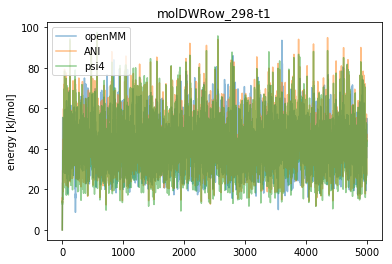

molDWRow_298


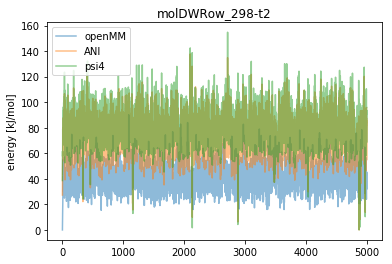

In [16]:
for t_id in [1, 2]:
    print(name)
    pot_energy_openMM = []
    pot_energy_ani = []
    pot_energy_psi4 = []

    with open(f"../data/md_sampling//{name}/{name}_tautomer_{t_id}_gaff_energy.csv", newline='') as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_openMM.append(float(row[2]))

    with open(f"../data/comparision_gaff_qm/{name}/ani_{name}_{t_id}.csv") as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_ani.append(float(row[1]))

    with open(f"../data/comparision_gaff_qm/{name}/psi4_energy_with_wB97X_631g_{name}_{t_id}.csv") as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_psi4.append(float(row[1]) * hartree_to_kJ_mol)

    pot_energy_openMM = list(np.asarray(pot_energy_openMM[::10]) - min(pot_energy_openMM[::10]))
    pot_energy_ani = list(np.asarray(pot_energy_ani) - min(pot_energy_ani))
    pot_energy_psi4 = list(np.asarray(pot_energy_psi4) - min(pot_energy_psi4))

    plt.plot(pot_energy_openMM, label='openMM', alpha=0.5 )
    plt.plot(pot_energy_ani, label='ANI', alpha=0.5)
    plt.plot(pot_energy_psi4, label='psi4', alpha=0.5)
    plt.title(f"{name}-t{t_id}")
    plt.legend()
    plt.ylabel('energy [kJ/mol]')

    plt.show()

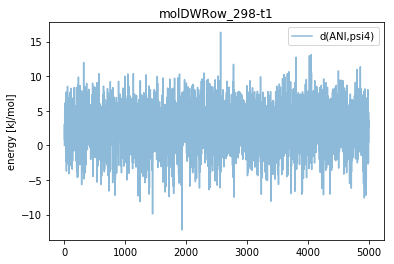

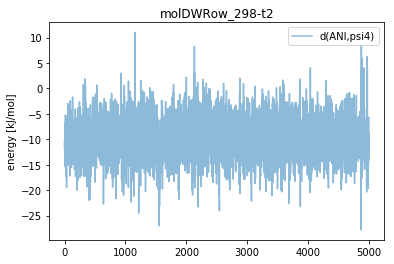

In [17]:
for t_id in [1, 2]:
    pot_energy_openMM = []
    pot_energy_ani = []
    pot_energy_psi4 = []

    with open(f"../data/md_sampling//{name}/{name}_tautomer_{t_id}_gaff_energy.csv", newline='') as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_openMM.append(float(row[2]))

    with open(f"../data/comparision_gaff_qm/{name}/ani_{name}_{t_id}.csv") as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_ani.append(float(row[1]))

    with open(f"../data/comparision_gaff_qm/{name}/psi4_energy_with_wB97X_631g_{name}_{t_id}.csv") as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy_psi4.append(float(row[1]) * hartree_to_kJ_mol)

    pot_energy_psi4 = list(np.asarray(pot_energy_psi4) - min(pot_energy_psi4))
    pot_energy_ani = list(np.asarray(pot_energy_ani) - min(pot_energy_ani) - pot_energy_psi4)

    plt.plot(pot_energy_ani, label='d(ANI,psi4)', alpha=0.5)
    #plt.plot(pot_energy_psi4, label='psi4', alpha=0.5)
    plt.title(f"{name}-t{t_id}")
    plt.legend()
    plt.ylabel('energy [kJ/mol]')

    plt.show()